In [275]:
import matplotlib.pyplot as plt
import librosa
import IPython.display 
import numpy as np
from pydub import AudioSegment
import plotly
import plotly.graph_objs as go 
import librosa.display
from scipy.io import wavfile
import tensorflow as tf
import soundfile

In [637]:
WAV_PREDICT_PATH = "test_dataset/Nattapol1min_2.m4a"
MODEL_PATH = "model/mfccDelta_model_multi.h5"
speaker_list = ['Nelson_Mandela', 'Julia_Gillard', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Natapol', 'Thitima']
# speaker_list = ['Natapol', 'Thitima']


In [638]:
from tensorflow import keras
model = keras.models.load_model(MODEL_PATH)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 58, 128)      1280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 29, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 27, 64)        73792     
                                                                 
 flatten_4 (Flatten)         (None, 103680)            0         
                                                                 
 dense_4 (Dense)             (None, 7)                 725767    
                                                                 
Total params: 800,839
Trainable params: 800,839
Non-trainable params: 0
________________________________________________

In [639]:
def load_wav_file(wav_path, plot = True) :
   if wav_path[-3:] != "wav" :
      audiofile = AudioSegment.from_file(wav_path)
      signal = np.array(audiofile.get_array_of_samples())
      fs = audiofile.frame_rate
      wav_path = "wav_file.wav"
      wavfile.write(wav_path, fs, signal)

   wav_data, sr = librosa.load(wav_path,sr=16000)

   if plot :
    plt.figure(figsize=(14, 5))
    plt.title('Signal')
    librosa.display.waveshow(wav_data, sr=sr)


   return wav_data, sr

(224768,)


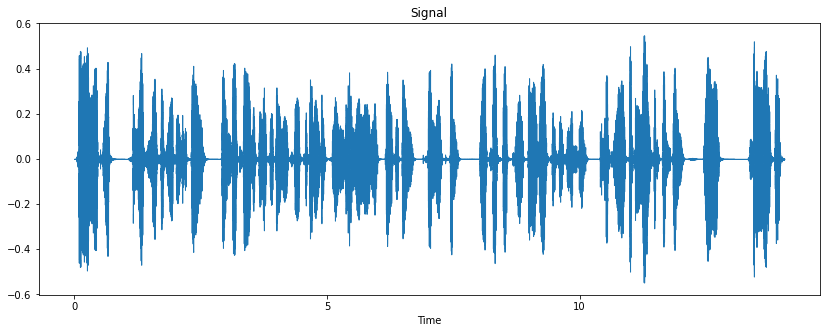

In [640]:
signal, sr = load_wav_file(WAV_PREDICT_PATH, plot=True)
print(np.shape(signal))

In [641]:
def segment_to_second(signal, fs) :
    # Fixed-sized segmentation (break a signal into non-overlapping segments)
    signal_len = len(signal)
    segment_size_t = 1 # segment size in seconds
    segment_size = int(segment_size_t * fs)  # segment size in samples
    # Break signal into list of segments in a single-line Python code
    segments = np.array([ signal[x:x + segment_size] for x in
                     np.arange(0, signal_len, segment_size)]  ,dtype=object)
    # Remove pauses using an energy threshold = 50% of the median energy:
    energies = [(s**2).sum() / len(s) for s in segments]
    thres = 0.5 * np.median(energies)
    index_of_segments_to_keep = (np.where(energies > thres)[0]) 
    segments = segments[index_of_segments_to_keep]
    if len(segments) > 1 :
        segments = segments[:-1]

    return segments

segments = segment_to_second(signal, sr)
print(segments.shape)



(13,)


In [642]:
# MFCC Feature Extraction
wavs_mfcc = []
wavs_mel = []
wavs_mfcc_all = []
for segment in segments:

        mfcc = librosa.feature.mfcc(y=np.array(segment,dtype="float32"), sr=sr,hop_length=128, n_fft=256, n_mfcc=20)
        wavs_mfcc.append(mfcc.T)

        mel = librosa.feature.melspectrogram(y=np.array(segment,dtype="float32"), sr=sr)
        wavs_mel.append(mel)

        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_double_delta = librosa.feature.delta(mfcc, order=2)
        mfcc_all = np.concatenate((mfcc,mfcc_delta,mfcc_double_delta),axis=0)
        wavs_mfcc_all.append(mfcc_all.T)
        
wavs_mfcc = np.expand_dims(wavs_mfcc,axis=3)
print(np.shape(wavs_mfcc))

wavs_mel = np.expand_dims(wavs_mel,axis=3)
print(np.shape(wavs_mel))

wavs_mfcc_all = np.expand_dims(wavs_mfcc_all,axis=3)
print(np.shape(wavs_mfcc_all))

(13, 126, 20, 1)
(13, 128, 32, 1)
(13, 126, 60, 1)


/Users/rew/opt/anaconda3/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [644]:
result = model.predict(wavs_mfcc_all)
result = [np.where(segment == max(segment)) for segment in result if np.where(segment == max(segment)) is not None]
result = np.squeeze(np.squeeze(result,1),1)
print(result)
counts = np.bincount(result)
print('Prediction Result: {}'.format(speaker_list[np.argmax(counts)]))


[5 5 5 5 5 5 5 5 5 5 5 5 5]
Prediction Result: Natapol


In [645]:
#  [1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1
#  0 0 1 0 0 1 1 0 0 1 1 1 1]